In [1]:
#import packages
import numpy as np
from numpy import loadtxt
import pylab as pl
from IPython import display
from RcTorchPrivate import *
from matplotlib import pyplot as plt
from scipy.integrate import odeint
import time

#this method will ensure that the notebook can use multiprocessing (train multiple 
#RC's in parallel) on jupyterhub or any other linux based system.
try:
    mp.set_start_method("spawn")
except:
    pass
torch.set_default_tensor_type(torch.FloatTensor)
%matplotlib inline
start_time = time.time()

### This notebook demonstrates how to use RcTorch to find optimal hyper-paramters for the differential equation $\dot y + q(t) y = f(t) $.

Simple population:  <font color='blue'>$\dot y + y =0$  </font>
* Analytical solution: <font color='green'>$y = y_0 e^{-t}$</font>

In [2]:
#define a reparameterization function, empirically we find that g= 1-e^(-t) works well)
def reparam(t, order = 1):
    
    exp_t = torch.exp(-t)
    derivatives_of_g = []
    
    g = 1 - exp_t
    g_dot = 1 - g
    return g, g_dot

In [3]:
def plot_results(RC, results, integrator_model, ax = None):
    """plots a RC prediction and integrator model prediction for comparison
    Parameters
    ----------
    RC: RcTorchPrivate.esn
        the RcTorch echostate network to evaluate. This model should already have been fit.
    results: dictionary
        the dictionary of results returned by the RC after fitting
    integrator model: function
        the model to be passed to odeint which is a gold standard integrator numerical method
        for solving ODE's written in Fortran. You may find the documentation here:
        https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html
    ax: matplotlib.axes._subplots.AxesSubplot
        If provided, the function will plot on this subplot axes
    """
    X = RC.X.detach().cpu()
    
    #int_sols = []
    if not ax:
        fig, ax = plt.subplots(1,1, figsize = (6,6))
    for i, y in enumerate(results["ys"]):
        if not i:
            labels = ["RC", "integrator solution"]
        else:
            labels = [None, None]
        y = y.detach().cpu()
        ax.plot(X, y, color = "blue", label = labels[0])

        #calculate the integrator prediction:
        int_sol = odeint(integrator_model, y0s[i], np.array(X.cpu().squeeze()))
        int_sol = torch.tensor(int_sol)
        #int_sols.append(int_sol)
        
        #plot the integrator prediction
        ax.plot(X, int_sol, '--', color = "red", alpha = 0.9, label = labels[1])
        
    ax.set_xlabel("time")
    ax.set_ylabel("y")
    ax.legend();
    #return int_sols

def plot_rmsr(RC, results, force, log = False, ax = None, RMSR = True):
    """plots the root mean square residuals (RMSR) of a RC prediction directly from the loss function
    Parameters
    ----------
    RC: RcTorchPrivate.esn
        the RcTorch echostate network to evaluate. This model should already have been fit.
    results: dictionary
        the dictionary of results returned by the RC after fitting
    force: function
        the force function describing the force term in the population equation
    ax: matplotlib.axes._subplots.AxesSubplot
        If provided, the function will plot on this subplot axes
    """
    if not ax:
        fig, ax = plt.subplots(1,1, figsize = (10, 4))
    X = RC.X.detach().cpu()
    ys, ydots = results["ys"], results["ydots"]
    
    residuals = []
    for i, y in enumerate(ys):
        y = y.detach().cpu()
        ydot = ydots[i].detach().cpu()
        resids = custom_loss(X, y, ydot, None, 
                             force = force, 
                             ode_coefs = RC.ode_coefs,
                             mean = False, reg = False)
        rmsr = torch.sqrt(resids)
        
        if not i:
            rmsr_tensor = rmsr
            label = "individual trajectory rmsr"
        else:
            rmsr_tensor = torch.cat((rmsr_tensor, rmsr), axis = 1)
            label = None
        
        if log:
            rmsr = torch.log10(rmsr)
            
        ax.plot(X, rmsr, color = "red", alpha = 0.4, label = label)
        residuals.append(resids)
    
    mean_rmsr = torch.mean(rmsr_tensor, axis =1)
    if log:
        mean_rmsr = torch.log10(mean_rmsr)
    ax.plot(X, mean_rmsr, 
                color = "blue", 
                alpha = 0.9, 
                label = "mean rmsr")

    ax.legend();
    
    ax.set_xlabel("time")
    if log:
        ax.set_ylabel("log rmsr")
    else:
        ax.set_ylabel("rmsr")
    print(torch.mean(mean_rmsr))

        

In [4]:
def force(X, A = 0):
    return torch.zeros_like(X)#A*torch.sin(X)
lam =1
def custom_loss(X , y, ydot, out_weights, lam = lam, force = force, reg = False, 
               ode_coefs = None, init_conds = None, 
                enet_alpha = None, enet_strength =None, mean = True):
    
    #with paramization
    L =  ydot  + lam * y - force(X)
    
    if reg:
        #assert False
        weight_size_sq = torch.mean(torch.square(out_weights))
        weight_size_L1 = torch.mean(torch.abs(out_weights))
        L_reg = enet_strength*(enet_alpha * weight_size_sq + (1- enet_alpha) * weight_size_L1)
        L = L + 0.1 * L_reg 
    
    L = torch.square(L)
    if mean:
        L = torch.mean(L)
    return L

In [5]:
#declare the bounds dict. We search for the variables within the specified bounds.
# if a variable is declared as a float or integer like n_nodes or dt, these variables are fixed.
bounds_dict = {"connectivity" : (-2, -0.5), #log space
               "spectral_radius" : (1, 2), #lin space
               "n_nodes" : 250, 
               "regularization" : (-4, 4), #log space
               "leaking_rate" : (0, 1),    #linear space
               "dt" : -2.75, #log space
               "bias": (-0.75,0.75) #linear space
               }

#set up data
BURN_IN = 500 #how many time points of states to throw away before starting optimization.
x0, xf = 0, 5
nsteps = int(abs(xf - x0)/(10**bounds_dict["dt"]))
xtrain = torch.linspace(x0, xf, nsteps, requires_grad=False).view(-1,1)
int(xtrain.shape[0] * 0.5)

1405

In [16]:
#declare the initial conditions (each initial condition corresponds to a different curve)
y0s = np.arange(0.1, 10.1, 0.1)
len(y0s)

100

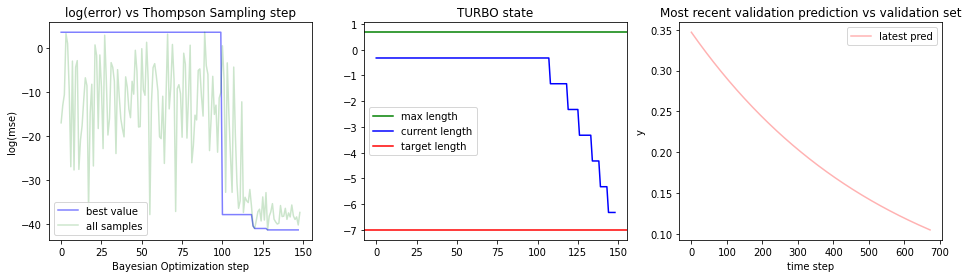

CPU times: user 6min 28s, sys: 1min 17s, total: 7min 46s
Wall time: 5min 16s


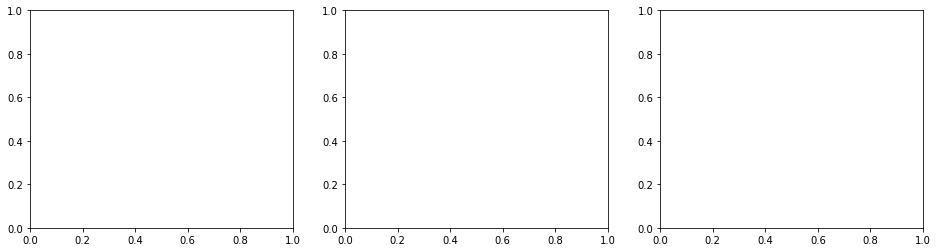

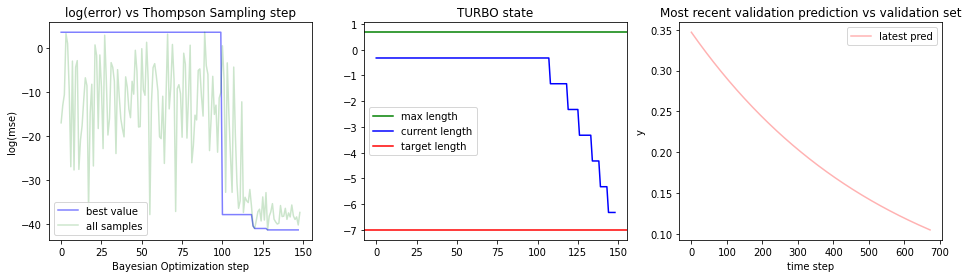

In [7]:
%%time
#declare the esn_cv optimizer: this class will run bayesian optimization to optimize the bounds dict.
#for more information see the github.
esn_cv = EchoStateNetworkCV(bounds = bounds_dict,
                            interactive = True, 
                            batch_size = 1, #batch size is parallel
                            cv_samples = 2, #number of cv_samples, random start points
                            initial_samples = 100, #number of random samples before optimization starts
                            subsequence_length = int(xtrain.shape[0] * 0.8), #combine len of tr + val sets
                            validate_fraction = 0.3, #validation prop of tr+val sets
                            log_score = True, #log-residuals
                            random_seed = 209, # random seed
                            ODE_order = 1, #order of eq
                            esn_burn_in = BURN_IN, #states to throw away before calculating output
                            #see turbo ref:
                            length_min = 2 **(-7), 
                            success_tolerance = 10, 
                            )
#optimize the network:
opt_hps = esn_cv.optimize(x = xtrain,
                        reparam_f = reparam, 
                        ODE_criterion = custom_loss,
                        init_conditions = [y0s], 
                        force = force,
                        ode_coefs = [1,1],
                        backprop_f = None,
                        n_outputs = 1,
                        eq_system = False)

In [8]:
# some particularly good runs:

# opt_hps = {'dt': 0.0031622776601683794,
#  'n_nodes': 250,
#  'connectivity': 0.7170604557008349,
#  'spectral_radius': 1.5755887031555176,
#  'regularization': 0.00034441529823729916,
#  'leaking_rate': 0.9272222518920898,
#  'bias': 0.1780446171760559}

# opt_hps = {'dt': 0.0017782794100389228,
#  'n_nodes': 250,
#  'connectivity': 0.11197846061157432,
#  'spectral_radius': 1.7452095746994019,
#  'regularization': 0.00012929296298723957,
#  'leaking_rate': 0.7733328938484192,
#  'bias': 0.1652531623840332}

In [9]:
opt_hps

{'dt': 0.0017782794100389228,
 'n_nodes': 250,
 'connectivity': 0.0494448023881578,
 'spectral_radius': 1.8282783031463623,
 'regularization': 0.00015106668569378855,
 'leaking_rate': 0.6425907015800476,
 'bias': 0.2018122673034668}

In [10]:
y0s = np.arange(-10, 10.1, 1)

In [17]:
%%time
RC = EchoStateNetwork(**opt_hps,
                         random_state = 209, 
                         dtype = torch.float32)

train_args = {"X" : xtrain.view(-1,1),        
              "burn_in" : int(BURN_IN), 
              "ODE_order" : 1,   
              "force" : force, 
              "reparam_f" : reparam,
              "ode_coefs" : [1, 1]}


results = RC.fit(init_conditions = [y0s,1],
                    SOLVE = True,
                    train_score = True, 
                    ODE_criterion = custom_loss,
                    **train_args)

CPU times: user 2.05 s, sys: 607 ms, total: 2.66 s
Wall time: 1.32 s


In [12]:
def simple_pop(y, t, t_pow = 0, force_k = 0, k = 1):
    dydt = -k * y *t**t_pow + force_k*np.sin(t)
    return dydt

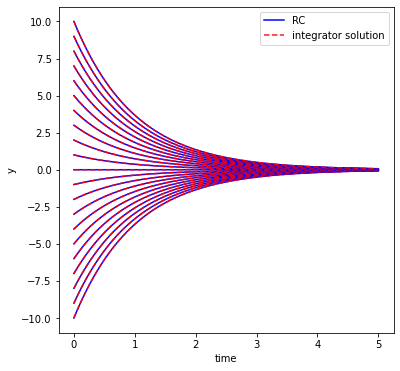

In [13]:
plot_results(RC, results, simple_pop)

tensor(-4.6113)


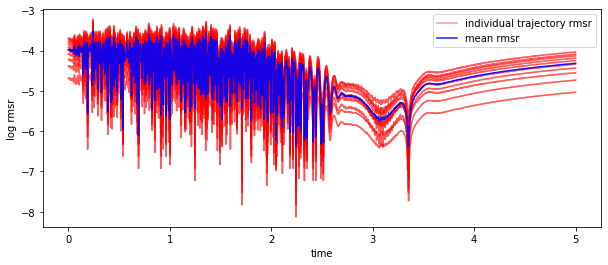

In [14]:
plot_rmsr(RC, results, force = force, log = True)

In [15]:
end_time = time.time()
print(f'Total notebook runtime: {end_time - start_time:.2f} seconds')

Total notebook runtime: 320.36 seconds
